In [1]:
import random
import numpy as np
import pandas as pd
import json

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

The following code segment was used to do a random sample without using too much memory.

In [2]:
yelp_reviews_raw = []
sample_count = 1000000

with open("yelp_academic_dataset_review.json", "r") as fp:
    full_size = sum([1 for _ in fp])
    sample_p = sample_count / full_size
    fp.seek(0)
    for entry in fp:
        if random.random() <= sample_p:
            yelp_reviews_raw.append(json.loads(entry))

yelp_reviews_sampled = pd.DataFrame(yelp_reviews_raw)
len(yelp_reviews_sampled.index)

1000385

In [3]:
yelp_reviews_sampled.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
1,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
2,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06
3,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45
4,z0osLHDvXvzfm57D4DmD2Q,xVKE_HJ2pwUtTdLbL3pnCg,S2Ho8yLxhKAa26pBAm6rxA,3.0,0,0,0,"Service was crappy, and food was mediocre. I ...",2016-11-22 00:22:53


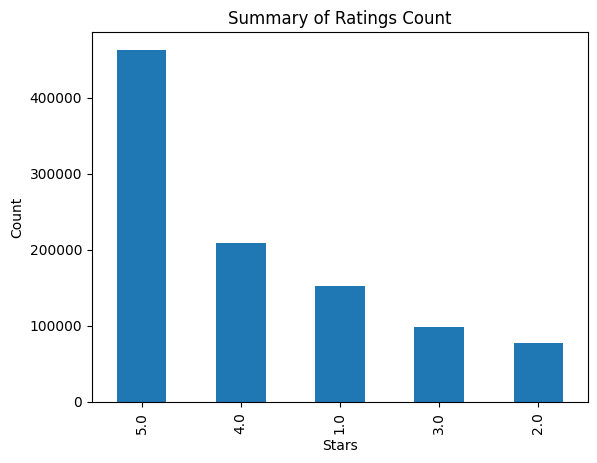

In [4]:
import matplotlib.pyplot as plt

ratings_summary = yelp_reviews_sampled["stars"].value_counts()
ratings_summary.plot.bar()
plt.title("Summary of Ratings Count")
plt.ylabel("Count")
plt.xlabel("Stars")
plt.show()

In [5]:
from datasets import Dataset
from transformers import AutoTokenizer

yelp_reviews_sampled["stars"] = yelp_reviews_sampled.stars.apply(lambda x: int(x) - 1)
yelp_reviews_sampled = yelp_reviews_sampled.rename(columns={"stars": "label"})
yelp_dicts = yelp_reviews_sampled[["text", "label"]].to_dict("records")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
yelp_dataset = Dataset.from_list(yelp_dicts).map(lambda x: tokenizer(x["text"], truncation=True), 
                                                 batched=True)
yelp_dataset

Map:   0%|          | 0/1000385 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1000385
})

In [6]:
train_testvalid = yelp_dataset.train_test_split(test_size=0.3)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
train, valid, test = train_testvalid["train"], test_valid["train"], test_valid["test"]
train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 700269
})

In [7]:
train.to_parquet("yelp_train_unbalanced.parquet")
valid.to_parquet("yelp_eval.parquet")
test.to_parquet("yelp_test.parquet")

Creating parquet from Arrow format:   0%|          | 0/701 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/151 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/151 [00:00<?, ?ba/s]

184980217